In [1]:
import torch
from torch.nn import Module
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import pickle

import matplotlib.pyplot as plt

In [2]:
targets = torch.load("../data/subset_train_targets.pt")
contexts = torch.load("../data/subset_train_contexts.pt")
labels = torch.load("../data/subset_train_labels.pt")

In [3]:
targets.shape

torch.Size([220930, 1])

In [4]:
contexts.shape

torch.Size([220930, 3])

In [5]:
labels.shape

torch.Size([220930, 3])

In [6]:
with open("../models/tokenizers/decode_token_to_h3.pickle", "rb") as f:
    decode_dict = pickle.load(f)

In [7]:
vocab_size = len(decode_dict.keys())

In [8]:
class Loc2VecDataset(Dataset):
    def __init__(self, targets, contexts, labels):
        super().__init__()
        self.targets = targets
        self.contexts = contexts
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.targets[idx], self.contexts[idx, :], self.labels[idx, :]

In [9]:
train_dataset = Loc2VecDataset(targets, contexts, labels)

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=128)

In [11]:
temp_embed = torch.nn.Embedding(vocab_size, 50)

In [12]:
for t, c, l in train_dataloader:
    print(f"Targets shape: {t.shape}")
    print(f"Contexts shape: {c.shape}")
    print(f"Labels shape: {l.shape}")
    print()
    
    t_embed = temp_embed(t)
    c_embed = temp_embed(c)
    print(f"Targets embedding shape: {t_embed.shape}")
    print(f"Contexts embedding shape: {c_embed.shape}")
    break

Targets shape: torch.Size([128, 1])
Contexts shape: torch.Size([128, 3])
Labels shape: torch.Size([128, 3])

Targets embedding shape: torch.Size([128, 1, 50])
Contexts embedding shape: torch.Size([128, 3, 50])


In [13]:
dot_products = torch.bmm(t_embed, 
                         c_embed.view(c_embed.shape[0], 
                                      c_embed.shape[2], 
                                      c_embed.shape[1])
                        )
dot_products = dot_products.reshape((dot_products.shape[0], dot_products.shape[2]))
print(f"Dot products shape: {dot_products.shape}")

Dot products shape: torch.Size([128, 3])


In [14]:
class Loc2Vec(Module):
    def __init__(self, vocab_size, embedding_size):
        super().__init__()
        self.target_embed = torch.nn.Embedding(vocab_size, embedding_size)
        self.context_embed = torch.nn.Embedding(vocab_size, embedding_size)
    def forward(self, target, context):
        target_embedding = self.target_embed(target)
        context_embedding = self.context_embed(context)
        dot_products = torch.bmm(target_embedding, context_embedding.view(context_embedding.shape[0], 
                                                                          context_embedding.shape[2], 
                                                                          context_embedding.shape[1]))
        dot_products = dot_products.reshape((dot_products.shape[0], 
                                             dot_products.shape[2]))
        return dot_products

In [15]:
temp_model = Loc2Vec(vocab_size, 100)

In [16]:
temp_out = temp_model(t, c)
print(f"Loc2Vec output shape: {temp_out.shape}")
print(f"Label shape: {l.shape}")

Loc2Vec output shape: torch.Size([128, 3])
Label shape: torch.Size([128, 3])


In [17]:
model = Loc2Vec(vocab_size, 100)

loss_func = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 20

In [18]:
losses = []
for epoch in range(EPOCHS):
    batch_losses = []
    for target, context, label in train_dataloader:
        pred = model(target, context)
        loss = loss_func(pred, label.float())
        batch_losses.append(loss)
        
        #Set gradients to zero
        optimizer.zero_grad()
        #Compute gradients
        loss.backward()
        #Update parameters with gradients and LR
        optimizer.step()
        
    batch_loss = sum(batch_losses) / len(batch_losses)
    batch_loss = batch_loss.detach().item()
    losses.append(batch_loss)
    if epoch % 2 == 0:
        print(batch_loss)

3.5492680072784424
1.7746052742004395
0.8328147530555725
0.37344691157341003
0.1593342125415802
0.06046232953667641
0.019329747185111046
0.0054251886904239655
0.0015241990331560373
0.00045098765986040235


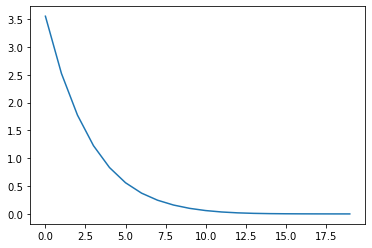

In [19]:
plt.plot(losses)

In [20]:
print(model)

Loc2Vec(
  (target_embed): Embedding(3685, 100)
  (context_embed): Embedding(3685, 100)
)


In [21]:
layers=[]
for layer in model.parameters():
    layers.append(layer)

In [22]:
target_embedding = layers[0]
context_embedding = layers[1]